# **<서울시 자치구별로 영화관, 인구데이터의 관계를 살펴보자>**

# **1. 유동인구/고정인구 관련 비교**
- 상관관계, 인과관계 알맞은 용어 찾기
1. [자치구] 지하철 승하차 인원을 더해서 유동인구수
  - 9/19(월)~9/25(일), 추석연휴의 이동 데이터 제외하기 위함.
2. [자치구별] 주민등록인구수로 고정인구수
3. [자치구별] 영화관 상영관 수 구하기

# **2. 인구수별 영화관 상영관 수 할당비율**
1. 인구수 / 영화관 상영관

# **3. 영화관의 규모 차이**
1. *영화관 별 상영관 수 평균을 구하고*
2. *평균 이상인 영화관을 규모가 큰 영화관으로 설정*

1-1. 구별로 상영관 수의 평균
3. 대규모 영화관의 분포를 살피고
4. 인구와의 관계를 살피자.

# **4. 영화관은 지하철역 근처에 많이 생기는 것 같다.**
- 직접역세권 500m, 간접역세권 1000m
- 지하철 역 근처에 평균 몇 개의 영화관이 위치하고 있을까?
1. 지하철 역별로 역세권에 속하는 영화관이 평균 몇 개인지 구하자.
2. 내림차순 정렬, 가장 많은 영화관이 근접한 전철역을 상위 추출하자.

**상관관계와 인과관계**
1. 인과관계 : 원인p에 따른 결과q
2. 상관관계 : A의 변화에따라 B가 증가하거나 감소함. 

In [253]:
from pandas.core.groupby.groupby import DataFrame
import pandas as pd
import re
#데이터 셋 만들기
#[지하철] 역id, 역이름, 승하차 횟수(7일합산), 주소, <행정구역번호>
#[주민등록인구] 구 이름, 인원수(10월), <행정구역번호>
#[영화관] 영화관수, 상영관수, 좌표x, 좌표y, <행정구역번호>
#[자치구] 행정구역번호, 행정구역이름(자치구)

cinema = pd.read_csv('/content/cinema.csv', encoding='utf-8') #영화관
pop = pd.read_csv('/content/population.csv', encoding='utf-8') #인구수
passenger = pd.read_csv('/content/subPassenger.csv', encoding='utf-8') #전철승하차
stat = pd.read_csv('/content/subStation.csv', encoding='utf-8') #전철역

#데이터 확인
# cinema.head()
# pop.head()
# postcode.head()
# passenger.head()
# stat.head()

#데이터 전처리
#1.영화관, cinema
# 영업상태코드(1) : 개방자치단체코드, 지번주소, 좌표정보(X), 좌표정보(Y), 사업장명
cin = cinema[['영업상태코드','개방자치단체코드','지번주소','좌표정보(X)','좌표정보(Y)', '사업장명']] #len: 899

is_open = cin['영업상태코드'] ==1 #영업중인 데이터만
cin=cin[is_open]

cin['행정구역'] = cinema.지번주소.str.split(' ').str[1] #구단위 행정구역 추출

cin #len:659
cin.to_csv('/content/result/cin.csv', encoding='utf-8-sig', index = None)

#2. 인구, pop
# 행정구역, 2022년10월_총인구수
pop = pop[['행정구역', '2022년10월_총인구수']]
pop.rename(columns = {'2022년10월_총인구수':'총인구수'},inplace=True)
#2-1. 연산 가능하도록
for i in range(len(pop)):
    pop['총인구수'][i] = re.sub(r',', '', pop['총인구수'][i])
pop['총인구수'] = pop['총인구수'].astype(int)

is_total = pop['행정구역'].str[-6:-1] == '00000' #object type, 구단위 데이터만 + 서울
is_seoul = pop['행정구역'].str[0:2] == '서울'
pop=pop[is_total & is_seoul]

#2-1 코드번호 열 생성
pop['구역코드'] = pop['행정구역'].str[-11:-1]
pop['행정구역'] = pop['행정구역'].str[6:-12] #구단위 이름만
pop.loc[0,'행정구역'] ='서울특별시'

pop #len: 26
pop.to_csv('/content/result/pop.csv', encoding='utf-8-sig', index = None)

#3. 지하철 역사 정보
#역번호, 역사명, 역위도(object->float), 역경도(float), 역사도로명주소
stat = stat[['역번호', '역사명', '역위도' ,'역경도', '역사도로명주소']] #len: 1049
stat['역위도'] = stat['역위도'].astype(float) #object -> float
stat.rename(columns = {'역사명':'역명'},inplace=True) #merge하기 위해

is_seoul = stat['역사도로명주소'].str[0:2] == '서울' #서울시내 역사만 추출
stat = stat[is_seoul]

stat['행정구역'] = stat.역사도로명주소.str.split(' ').str[1] #구단위 행정구역 추출

stat['역명'] = stat['역명'].str.rstrip('역').copy() #xx'역' 제거
# print(stat)

stat #len: 390
stat.to_csv('/content/result/stat.csv', encoding='utf-8-sig', index = None)

#4. 지하철 승차 정보
# 사용일자(object->int), 노선명, 역명(int->str), 승차총승객수, 하차총승객수
passenger = passenger.drop(columns = '등록일자')
passenger['역명'] = passenger['역명'].astype(str)
passenger['사용일자'] = passenger['사용일자'].astype(int)

#4-1. 9/19(월)~9/25(일) 데이터만
weekstart = passenger['사용일자'] > 20220918
weekend = passenger['사용일자'] < 20220926 
passenger = passenger[weekstart & weekend]
passenger['사용일자'] = passenger['사용일자'].astype(str)

psg = passenger.groupby('역명').sum()
psg = psg.rename_axis('역명').reset_index() #인덱스명을 열로 만들기

#4-2. 괄호와 괄호 안 문자 제거
for i in range(len(psg)):
    psg['역명'][i] = re.sub(r'\([^)]*\)', '', psg['역명'][i])
    # print(psg['역명'][i])

psg #len: 523
psg.to_csv('/content/result/psg.csv', encoding='utf-8-sig', index = None)

#5. 4번과 5번 합치기 subway = stat + psg

# #5-2. 역명 기준으로 merge
# stat.rename(columns = {'역사명':'역명'},inplace=True) 
# subway = pd.merge(stat,psg, how='outer',on='역명')

# subway
# subway.to_csv('/content/result/subway.csv', encoding='utf-8-sig', index = None)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [254]:
from functools import reduce
from os import stat_result
from pandas.core.groupby.groupby import DataFrame
import pandas as pd

cin = pd.read_csv('/content/result/cin.csv', encoding='utf-8') 
pop = pd.read_csv('/content/result/pop.csv', encoding='utf-8')
psg = pd.read_csv('/content/result/psg.csv', encoding='utf-8')
stat = pd.read_csv('/content/result/stat.csv', encoding='utf-8')
subway = pd.read_csv('/content/result/subway.csv', encoding='utf-8')

#행정구역별로 카운팅

#1. 영화상영관, cnt_cinema
cnt_cin = cin[['행정구역','영업상태코드']].groupby('행정구역').count()
cnt_cin = cnt_cin.rename_axis('행정구역').reset_index() #인덱스명을 열로 만들기
cnt_cin.rename(columns = {'영업상태코드':'상영관개수'},inplace=True) 
# print(cnt_cin)

#2. 인구, pop
cnt_pop = pop.drop(pop.index[0]) #merge 어려움
cnt_pop = cnt_pop.set_index('행정구역') #열명으로 인덱스 만들기
cnt_pop = cnt_pop.sort_index() #정렬
cnt_pop = cnt_pop.rename_axis('행정구역').reset_index() #인덱스명을 열로 만들기
cnt_pop['행정구역'] = cnt_pop['행정구역'].str.strip().copy() #공백 제거

cnt_pop = cnt_pop.drop(columns = '구역코드')

#3. 전철역사, cnt_stat
cnt_stat = stat[['행정구역','역명']].groupby('행정구역').count()
cnt_stat = cnt_stat.rename_axis('행정구역').reset_index() #인덱스명을 열로 만들기
cnt_stat.rename(columns = {'역명':'역사개수'},inplace=True) 
# print(cnt_stat)

#4. 전철승하차, cnt_psg
#4-1. 환승역 중복 제거
stat.drop_duplicates(['역명'], inplace=True) #len: 390->307

#4-2. subway = stat + psg, 역명 기준으로 merge
subway = pd.merge(stat,psg, how='inner',on='역명') #len: 248 ********************* 결측 가능성 있음.**********************

#4-3. cnt_psg
cnt_psg = subway[['행정구역','승차총승객수', '하차총승객수']].groupby('행정구역').sum()
cnt_psg['총승객수'] = cnt_psg['승차총승객수'] + cnt_psg['하차총승객수']

cnt_psg = cnt_psg.drop(columns = '승차총승객수')
cnt_psg = cnt_psg.drop(columns = '하차총승객수')

cnt_psg = cnt_psg.rename_axis('행정구역').reset_index() #인덱스명을 열로 만들기

# print(cnt_psg)

subway.to_csv('/content/result/subway.csv', encoding='utf-8-sig', index = None)

#5. 전체 cnt 합치기
# print(cnt_pop)
# cnt_cin.info()
# cnt_pop.info()
# cnt_stat.info()
# cnt_psg.info()

# cnts = pd.merge(cnt_cin, cnt_stat, on='행정구역', how='inner')
# cnts = pd.merge(cnts, cnt_psg, on='행정구역', how='inner')
# cnts = pd.merge(cnts, cnt_pop, on='행정구역', how='outer')
# # print(cnts)

cnts = [cnt_cin, cnt_pop, cnt_stat, cnt_psg]

df_cnts = reduce(lambda left, right: pd.merge(left, right, on='행정구역'), cnts) #여러 개 한번에 merge
df_cnts

df_cnts.to_csv('/content/result/df_result.csv', encoding='utf-8-sig', index = None)


# **시각화**

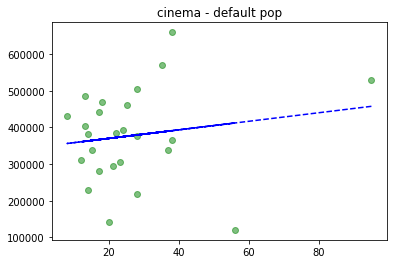

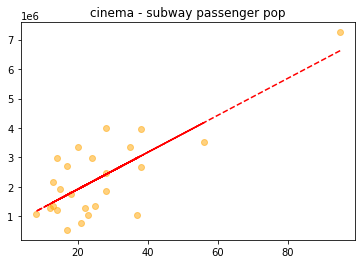

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

#subway passenger pop
#default pop

df = pd.read_csv('/content/result/df_result.csv', encoding='utf-8') 
df

#산점도(scatter), 추세선(trend line)
#1. 고정인구
x=df['상영관개수']
y=df['총인구수']

plt.scatter(x, y, alpha=0.5, c='g')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", c='blue')

plt.title('cinema - default pop')
plt.show()

# z = np.polyfit(x, y, 1) # x, y, 차원
# p = np.poly1d(z) # 1차원 다항식에 대한 연산을 캡슐화

# # 그래프 그리기
# pylab.plot(x,y,'o') #산점도: o
# pylab.plot(x,p(x),"r")

#2. 유동인구
x=df['상영관개수']
y=df['총승객수']

plt.scatter(x, y, alpha=0.5, c='orange')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", c='red')

plt.title('cinema - subway passenger pop')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   행정구역    25 non-null     object
 1   상영관개수   25 non-null     int64 
 2   총인구수    25 non-null     int64 
 3   역사개수    25 non-null     int64 
 4   총승객수    25 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.1+ KB


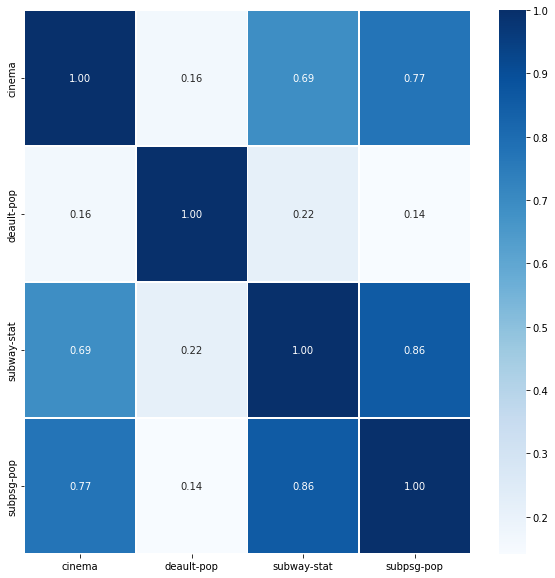

In [256]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import seaborn as sns #히트맵

#subway passenger pop
#default pop

df = pd.read_csv('/content/result/df_result.csv', encoding='utf-8')
df.info()
df.columns = ['gu','cinema','deault-pop','subway-stat','subpsg-pop'] #한글 지원 안됨

plt.figure(figsize=(10,10))
#annot : 각 셀 값 표시, fmt: 소수점자리
sns.heatmap(data = df.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [261]:
#트리맵, 한글 깨짐. 상위데이터만 추출합니다.

import pandas as pd

df = pd.read_csv('/content/result/df_result.csv', encoding='utf-8')
df.info()

# df.nlargest(5, '상영관개수') #강남구, 중구, 마포구, 송파구, 광진구
# df.nlargest(5, '총인구수') #송파구, 강서구, 강남구, 노원구, 관악구
# df.nlargest(5, '총승객수') #강남구, 영등포구, 마포구, 중구, 종로구
df.nlargest(5, '역사개수') #강남구, 중구, 강서구, 마포구, 동작구

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   행정구역    25 non-null     object
 1   상영관개수   25 non-null     int64 
 2   총인구수    25 non-null     int64 
 3   역사개수    25 non-null     int64 
 4   총승객수    25 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.1+ KB
   행정구역  상영관개수    총인구수  역사개수     총승객수
0   강남구     95  529946    32  7251659
23   중구     56  120648    23  3517925
12  마포구     38  364698    22  3974855
17  송파구     38  659788    21  2669525
5   광진구     37  337900    11  1034741
   행정구역  상영관개수    총인구수  역사개수     총승객수
17  송파구     38  659788    21  2669525
3   강서구     35  570011    22  3358883
0   강남구     95  529946    32  7251659
8   노원구     28  505058    16  2457976
4   관악구     13  487201     9  1358155
    행정구역  상영관개수    총인구수  역사개수     총승객수
0    강남구     95  529946    32  7251659
19  영등포구     28  375849    21  4001998
12   마포구     38  364698

In [257]:
#1.영화관 개수 등치지역도

import folium #지도
import pandas as pd

df = pd.read_csv('/content/result/df_result.csv', encoding='utf-8')
df.info()
data = df[['행정구역', '상영관개수']]

#구별로 나뉜 서울시 지도
geo_json='https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'

m = folium.Map(location=[37.566345, 126.977893],
               tiles='Stamen Terrain')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=data,
    columns=['행정구역','상영관개수'],
    key_on='feature.properties.name', #jsonfile의 내용
    fill_color='YlGn', #yellow->green
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   행정구역    25 non-null     object
 1   상영관개수   25 non-null     int64 
 2   총인구수    25 non-null     int64 
 3   역사개수    25 non-null     int64 
 4   총승객수    25 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.1+ KB


In [250]:
#2.고정인구수 등치지역도

import folium #지도
import pandas as pd

df = pd.read_csv('/content/result/df_result.csv', encoding='utf-8')
df.info()
data = df[['행정구역', '총인구수']]

#구별로 나뉜 서울시 지도
geo_json='https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'

m = folium.Map(location=[37.566345, 126.977893],
               tiles='Stamen Terrain')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=data,
    columns=['행정구역','총인구수'],
    key_on='feature.properties.name', #jsonfile의 내용
    fill_color='YlGn', #yellow->green
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   행정구역    25 non-null     object
 1   상영관개수   25 non-null     int64 
 2   총인구수    25 non-null     int64 
 3   역사개수    25 non-null     int64 
 4   총승객수    25 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.1+ KB


In [251]:
#2.유동인구수 등치지역도 - 역사개수

import folium #지도
import pandas as pd

df = pd.read_csv('/content/result/df_result.csv', encoding='utf-8')
df.info()
data = df[['행정구역', '역사개수']]

#구별로 나뉜 서울시 지도
geo_json='https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'

m = folium.Map(location=[37.566345, 126.977893],
               tiles='Stamen Terrain')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=data,
    columns=['행정구역','역사개수'],
    key_on='feature.properties.name', #jsonfile의 내용
    fill_color='YlGn', #yellow->green
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   행정구역    25 non-null     object
 1   상영관개수   25 non-null     int64 
 2   총인구수    25 non-null     int64 
 3   역사개수    25 non-null     int64 
 4   총승객수    25 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.1+ KB


In [252]:
#2.유동인구수 등치지역도 - 승하차승객

import folium #지도
import pandas as pd

df = pd.read_csv('/content/result/df_result.csv', encoding='utf-8')
df.info()
data = df[['행정구역', '총승객수']]

#구별로 나뉜 서울시 지도
geo_json='https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'

m = folium.Map(location=[37.566345, 126.977893],
               tiles='Stamen Terrain')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=data,
    columns=['행정구역','총승객수'],
    key_on='feature.properties.name', #jsonfile의 내용
    fill_color='YlGn', #yellow->green
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   행정구역    25 non-null     object
 1   상영관개수   25 non-null     int64 
 2   총인구수    25 non-null     int64 
 3   역사개수    25 non-null     int64 
 4   총승객수    25 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.1+ KB
